### __Solving ODE using NN__

In [125]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NeuralNet(nn.Module):
    def __init__(self, hidden_size, output_size=1,input_size=1):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.LeakyReLU()
        self.l4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l4(out)
        return out

In [126]:
# Create the criterion that will be used for the DE part of the loss
criterion = nn.MSELoss()

# Define the loss function for the initial condition
def initial_condition_loss(y, target_value):
    return nn.MSELoss()(y, target_value)

In [200]:
# Time vector that will be used as input of our NN
t_numpy = np.arange(0, 5+0.01, 0.01, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)

# Constant for the model
k = 1
def f(y):
    return -k * y

# Instantiate one model with 50 neurons on the hidden layers
model = NeuralNet(hidden_size=50)

# Loss and optimizer
learning_rate = 8e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = int(100)
for epoch in range(num_epochs):
    t_train = t
    # Forward pass
    y_pred = model(t_train)
    # Calculate the derivative of the forward pass w.r.t. the input (t)
    dy_dt = torch.autograd.grad(y_pred, 
                                t_train, 
                                grad_outputs=torch.ones_like(y_pred), 
                                create_graph=True)[0]
    # Define the differential equation and calculate the loss
    loss_DE = criterion(dy_dt - f(y_pred), torch.zeros_like(dy_dt))
    # Define the initial condition loss
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), 
                                     torch.tensor([[1.0]]))
    loss = loss_DE + loss_IC
    # Backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

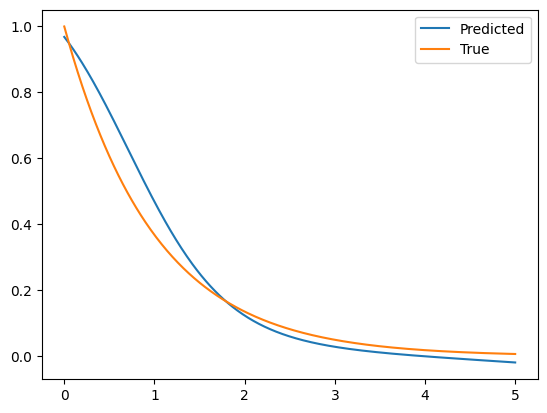

In [201]:
# Visualize the results
import matplotlib.pyplot as plt
plt.plot(t_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), label='Predicted')
plt.plot(t_train.cpu().detach().numpy(), torch.exp(-t_train).cpu().detach().numpy(), label='True')
plt.legend()
plt.show()


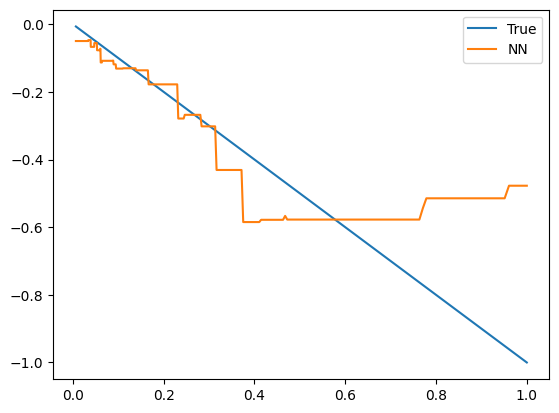

In [192]:
import pandas as pd

y_true = torch.exp(-t_train).cpu().detach().numpy().reshape(-1)
dydt_true = f(y_true)

res = pd.DataFrame()
res['true'] = dydt_true
res['NN'] = dy_dt.cpu().detach().numpy().reshape(-1)

# Plot the results
plt.plot(y_true, dydt_true, label='True')
plt.plot(y_true, dy_dt.cpu().detach().numpy().reshape(-1), label='NN')
plt.legend()
plt.show()


100%|██████████| 10000/10000 [00:14<00:00, 682.75it/s]


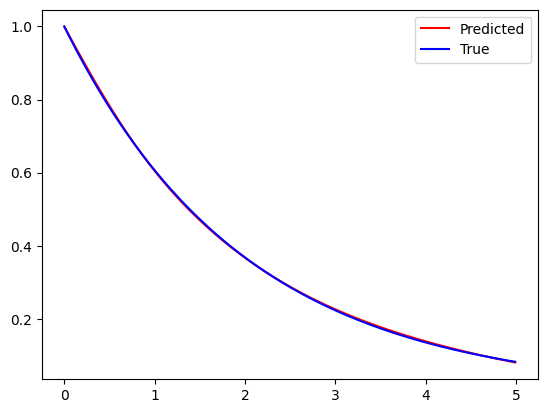

In [319]:
# Time vector that will be used as input of our NN
t_numpy = np.arange(0, 5, 0.01, dtype=np.float32)
t = torch.from_numpy(t_numpy).reshape(len(t_numpy), 1)
t.requires_grad_(True)

# Constant for the model
k = 0.5
def f(y):
    return -k * y

# Instantiate one model with 50 neurons on the hidden layers
model = NeuralNet(hidden_size=50)

# Loss and optimizer
learning_rate = 8e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = int(10000)
for epoch in tqdm(range(num_epochs)):
    t_train = t
    # Forward pass
    y_pred = model(t_train)
    # Calculate the derivative of the forward pass w.r.t. the input (t)
    dy_dt = torch.autograd.grad(y_pred, 
                                t_train, 
                                grad_outputs=torch.ones_like(y_pred), 
                                create_graph=True)[0]
    # Define the differential equation and calculate the loss
    loss_DE = criterion(dy_dt - f(y_pred), torch.zeros_like(dy_dt))
    # Define the initial condition loss
    loss_IC = initial_condition_loss(model(torch.tensor([[0.0]])), 
                                     torch.tensor([[1.0]]))
    loss = loss_DE + loss_IC
    # Backward pass and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
# Visualize the results
import matplotlib.pyplot as plt

y_pred = model(t_train)
y_true = torch.exp(- k * t_train).cpu().detach().numpy()
plt.plot(t_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), label='Predicted', color='red')
plt.plot(t_train.cpu().detach().numpy(), y_true, label='True', color='blue')
plt.legend()
plt.show()


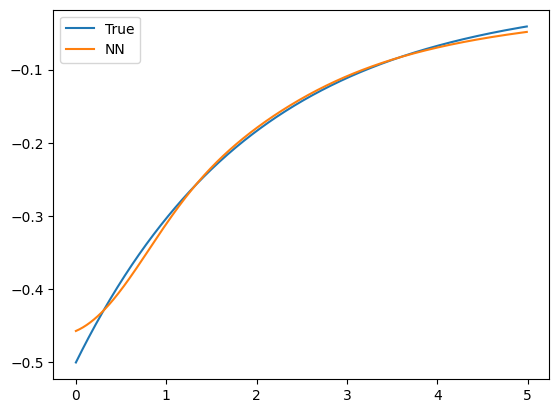

In [321]:
# plot the derivatives
dydt_true = f(y_true)
dy_dt = torch.autograd.grad(y_pred, 
                            t_train, 
                            grad_outputs=torch.ones_like(y_pred), 
                            create_graph=True)[0]

plt.plot(t_train.cpu().detach().numpy(), dydt_true, label='True')
plt.plot(t_train.cpu().detach().numpy(), dy_dt.cpu().detach().numpy().reshape(-1), label='NN')
plt.legend()
plt.show()
